In [1]:
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("CategoricalArrays")
Pkg.add("StatsPlots")
Pkg.add("Statistics")
Pkg.add("ColorSchemes")
using CSV
using DataFrames
using LinearAlgebra
using Dates
using Plots
using CategoricalArrays
using StatsPlots
using Statistics

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`
   Resolving package versions...
  No Ch

In [2]:
function pct_change(input)
    res = @view(input[5:end]) ./ @view(input[1:end-4]) .- 1
    [missing; missing; missing; missing; res]
end

pct_change (generic function with 1 method)

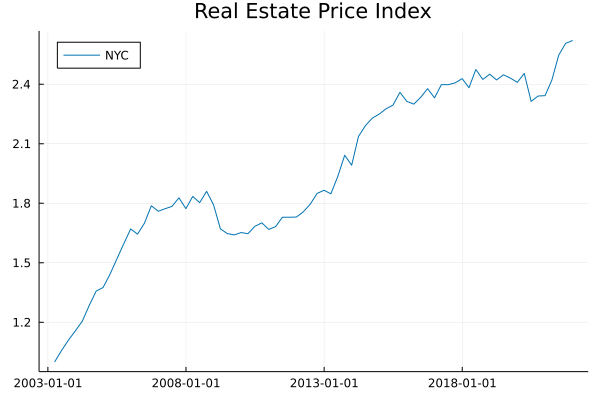

In [3]:
df = CSV.read("nyc_real_estate_211231.csv", 
    DataFrame; select=[ :uid, :sale_price, :sale_date, :borough, :house_class, :neighborhood],
    types=Dict(:uid=>String, :sale_price=>Int64, :sale_date=>Date)) |> 
    df -> sort(df, [:uid, :sale_date])
df.sale_date = Dates.lastdayofquarter.(df.sale_date)
dropmissing!(df)

grouped = groupby(df, [:borough, :uid])
df = df[combine(grouped, :sale_price => (x -> median(x) / 4 .< x .< median(x) * 4) => :is_clean).is_clean, :]
grouped = groupby(df, [:borough, :uid])
grouped = grouped[combine(grouped, nrow).nrow .> 1]
df = combine(grouped, names(df)...)

function calc_index(df)
    grouped = groupby(df, [:borough, :uid])

    rng = sort(unique(df.sale_date))

    n = sum(combine(grouped, gp -> nrow(gp) - 1).x1)
    X = zeros(Int64, (n, size(rng, 1)))   # first column of X will become Y vector
    Δ = zeros(Int64, (n, 1))
    row = 1

    for group in grouped
        for i in 1:size(group,1)-1
            buy = group[i, :]
            sell = group[i+1, :]
            q₁ = findfirst(rng .== buy.sale_date)
            q₂ = findfirst(rng .== sell.sale_date)
            X[row, q₁] = -buy.sale_price
            X[row, q₂] = sell.sale_price
            Δ[row] = q₂ - q₁ 
            row += 1
        end
    end

    Y = -X[:, 1]
    X = X[:, 2:end]
    Z = sign.(X)

    β = inv(Z'X)Z'Y

    e = (Y - X * β)[:]
    h = inv(Δ' * Δ) * Δ' * e.^2
    h = max.(h, 0)

    w = sqrt.(Δ * h)[:]
    ω = 1 ./ w
    Ω = Diagonal(w)

    β = inv(Z' * inv(Ω) * X) * Z' * inv(Ω) * Y
    insert!(β, 1, 1)
    return DataFrame(index=1 ./ β, dates=rng)
end

rng = sort(unique(df.sale_date))
idx = calc_index(df)
plot(idx.dates, idx.index, label="NYC", legend=:topleft, title="Real Estate Price Index", palette=:seaborn_colorblind)

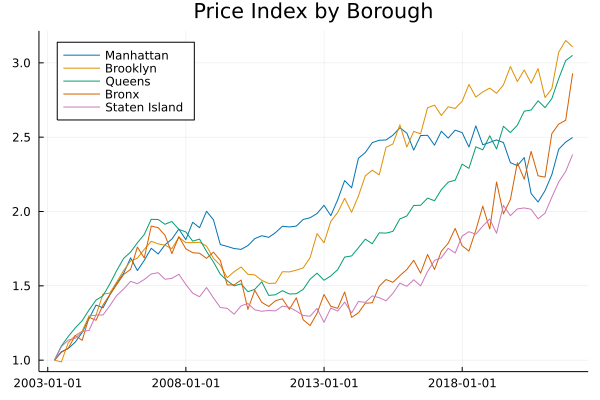

,neighborhood,pct_chg
,String,Float64
1,Manhattan,0.167102
2,Brooklyn,0.123255
3,Queens,0.130302
4,Bronx,0.313077
5,Staten Island,0.198552


In [4]:
gdf = groupby(df, :borough)
idxb = combine(gdf) do sdf
    calc_index(sdf)
end
idxb = unstack(idxb, :borough, :index)
display(@df idxb plot(:dates, cols(2:6), legend=:topleft, title="Price Index by Borough", palette=:seaborn_colorblind))
yoy = select(idxb, [1] .=> :date, Symbol.(names(idxb)[2:end]) .=> pct_change; renamecols=false)
DataFrame([names(yoy)[2:end], collect(yoy[end, 2:end])], [:neighborhood, :pct_chg])

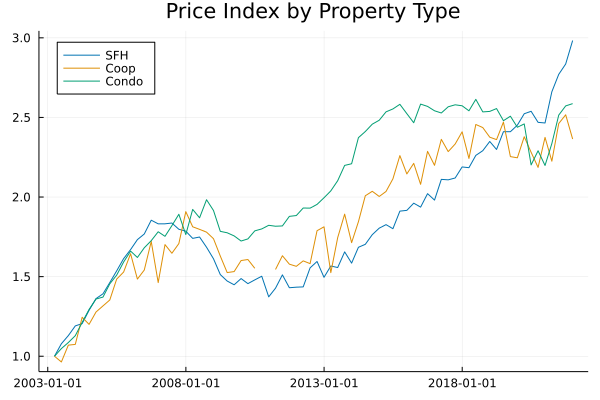

,neighborhood,pct_chg
,String,Float64
1,SFH,0.210119
2,Coop,-0.00438317
3,Condo,0.176684


In [5]:
gdf = groupby(df, :house_class)
idxb = combine(gdf) do sdf
    calc_index(sdf)
end
idxb = unstack(idxb, :house_class, :index)
display(@df idxb plot(:dates, cols(2:4), legend=:topleft, title="Price Index by Property Type", palette=:seaborn_colorblind))
yoy = select(idxb, [1] .=> :date, Symbol.(names(idxb)[2:end]) .=> pct_change; renamecols=false)
DataFrame([names(yoy)[2:end], collect(yoy[end, 2:end])], [:neighborhood, :pct_chg])

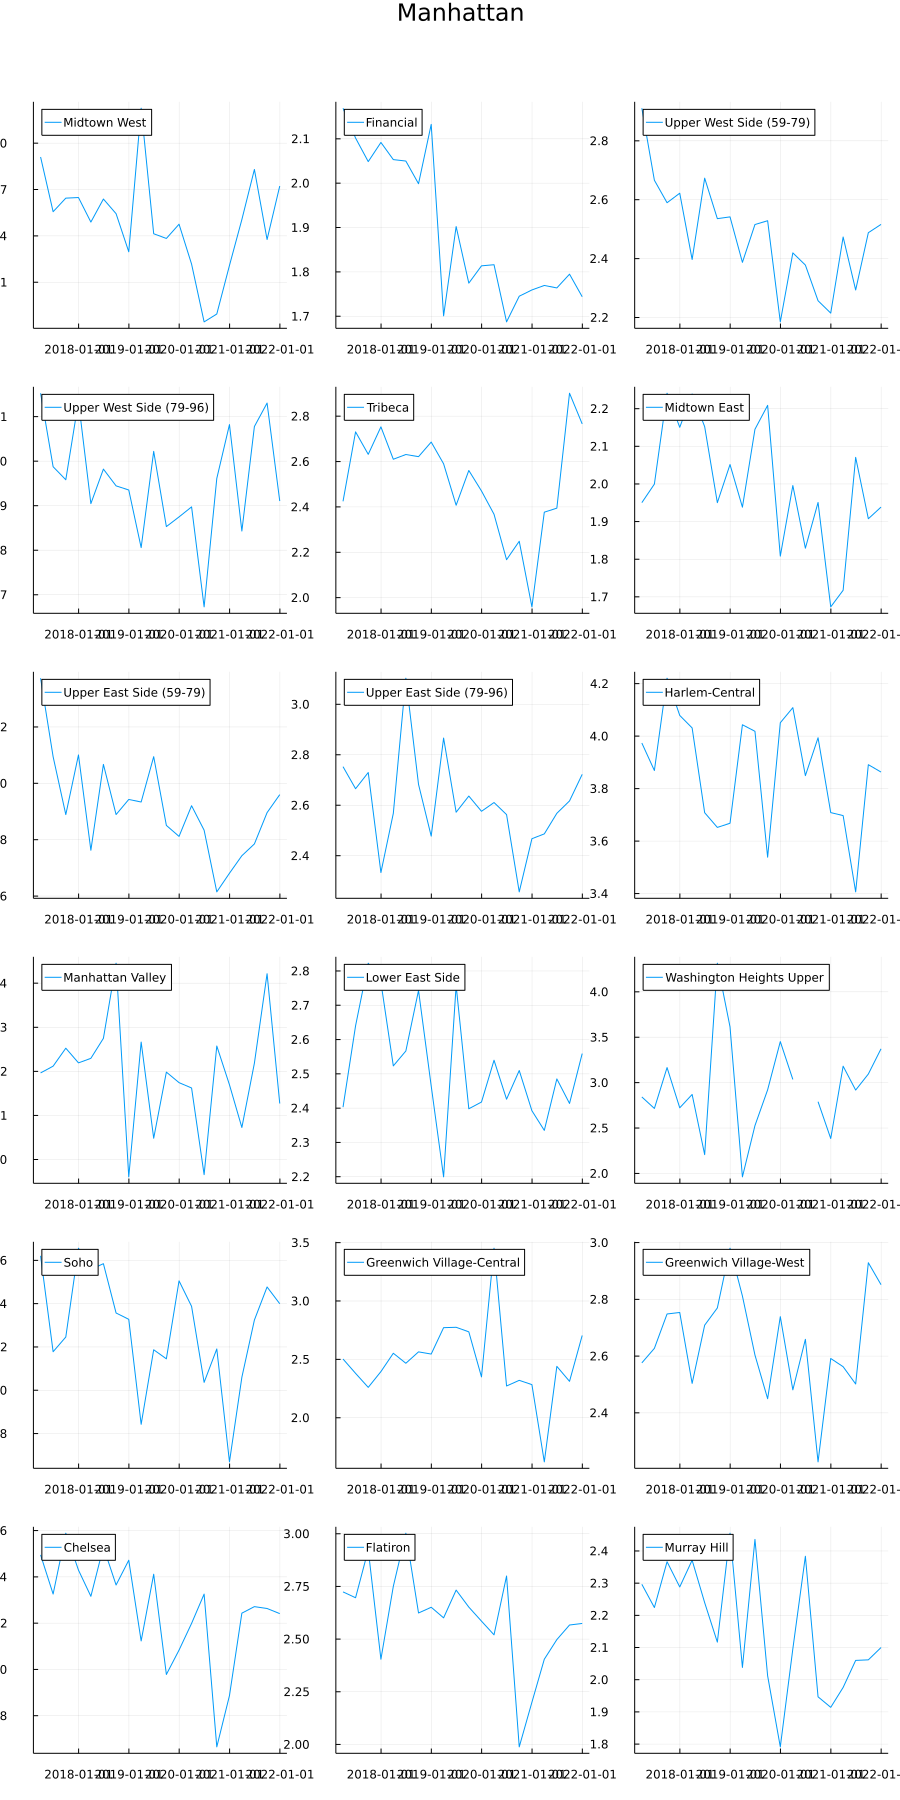

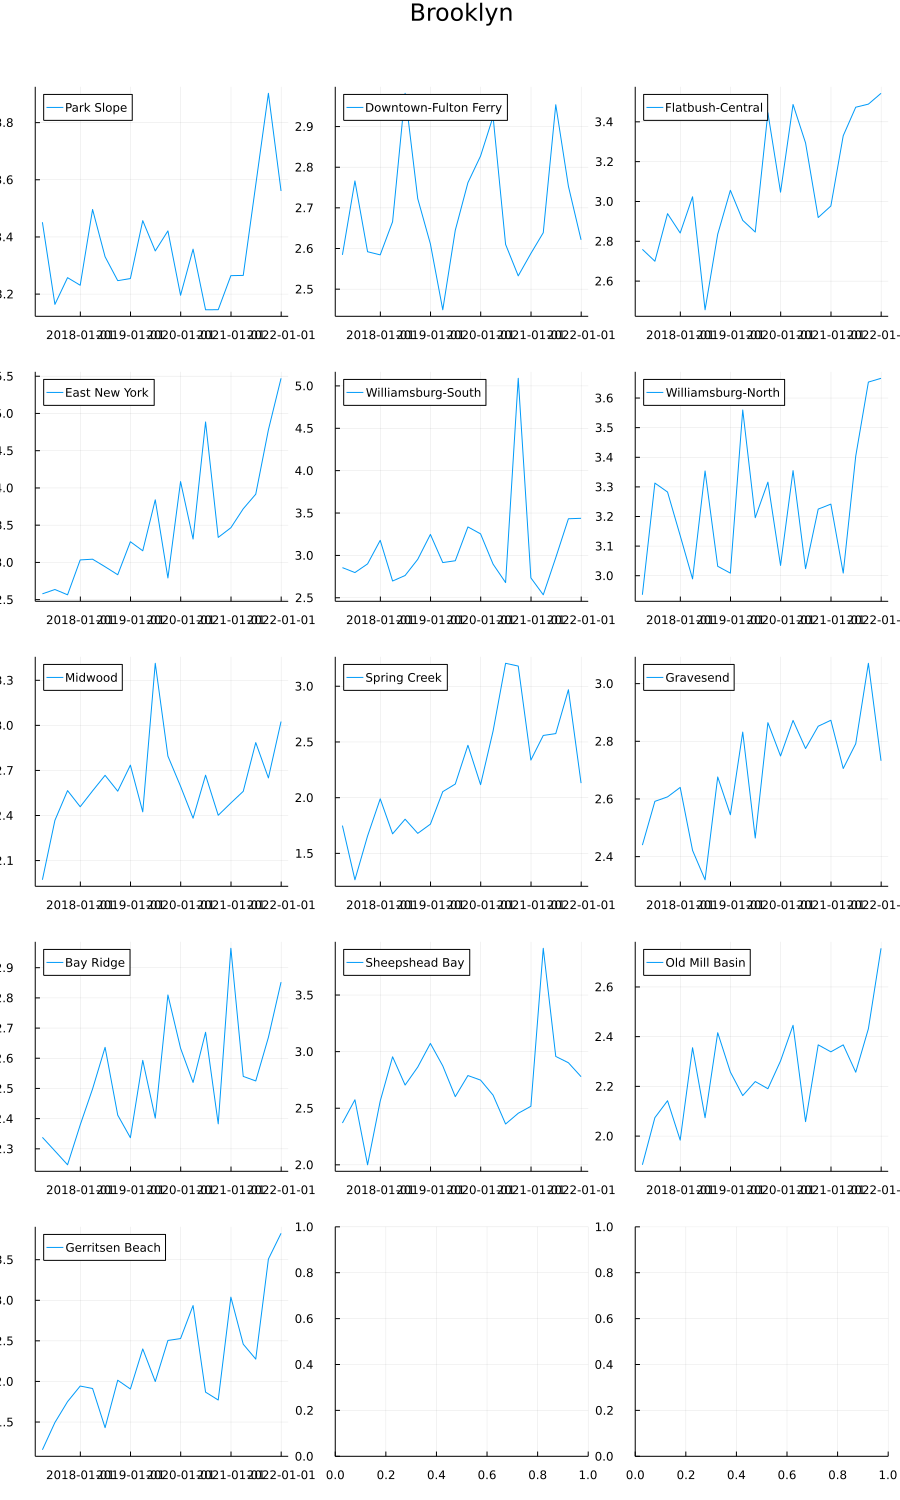

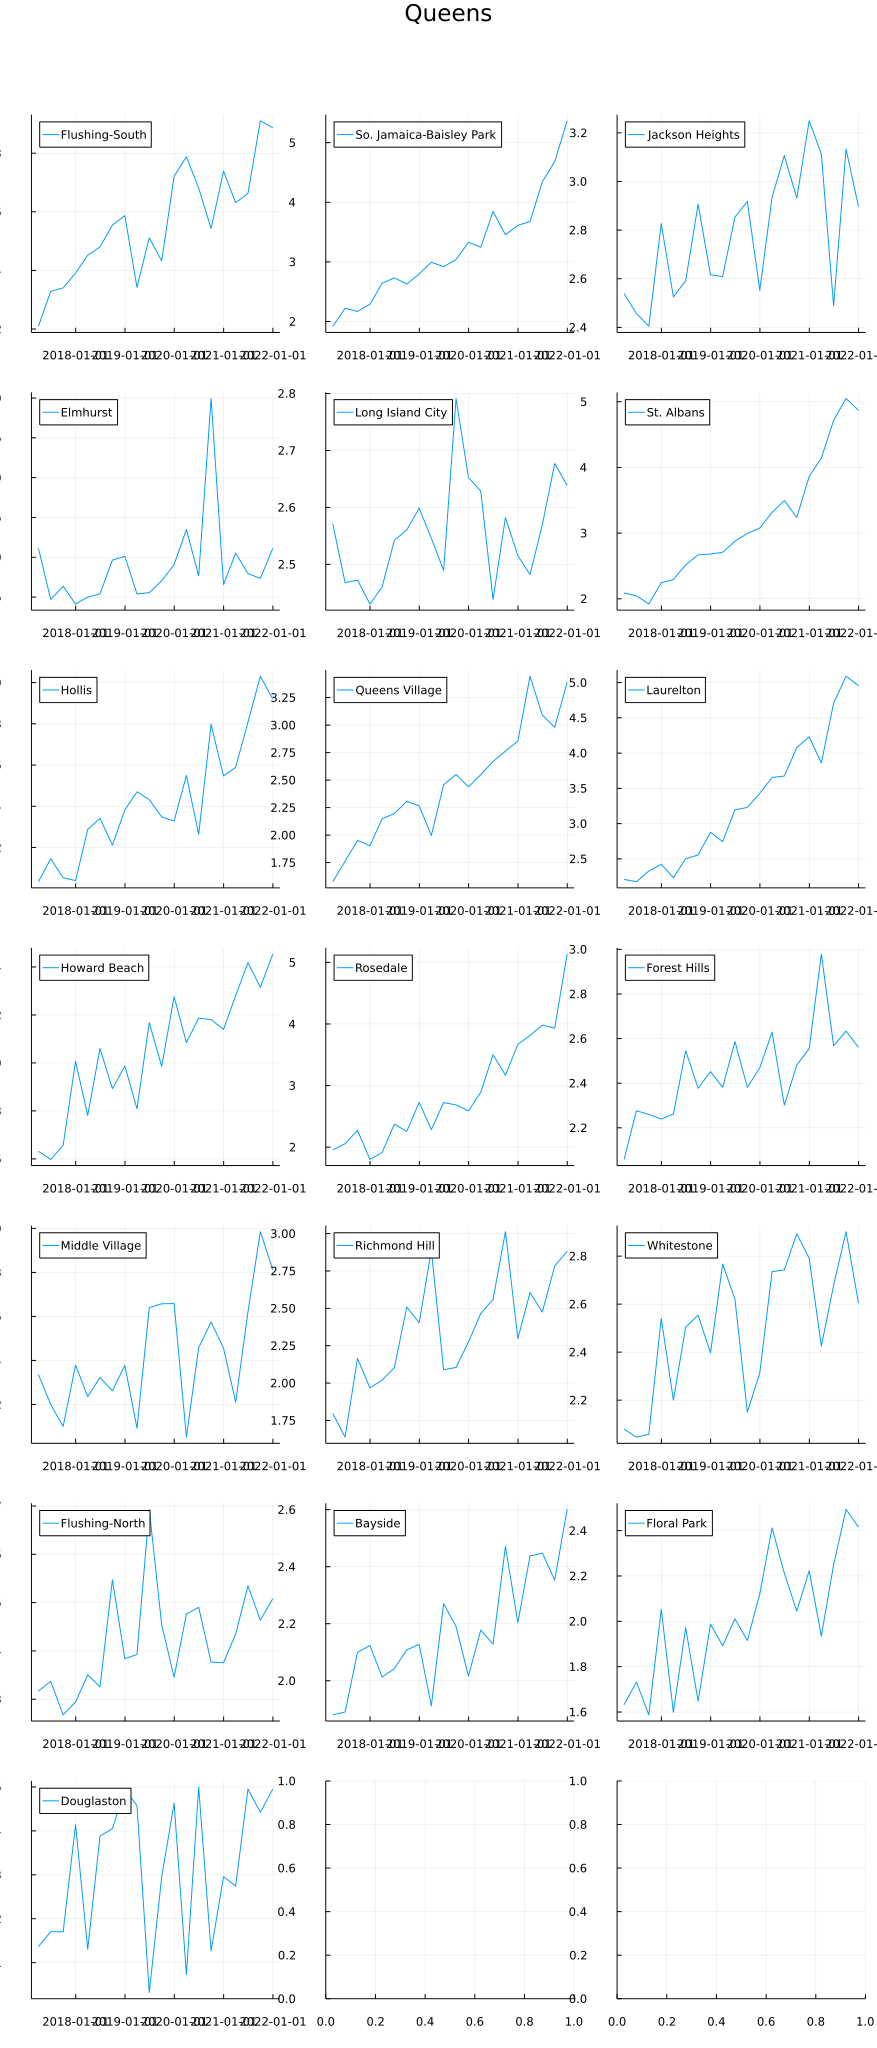

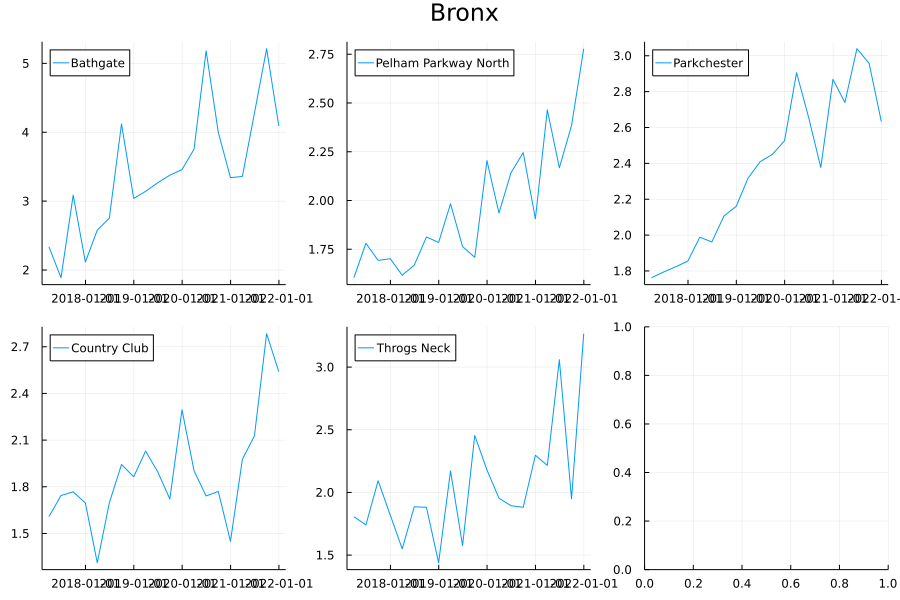

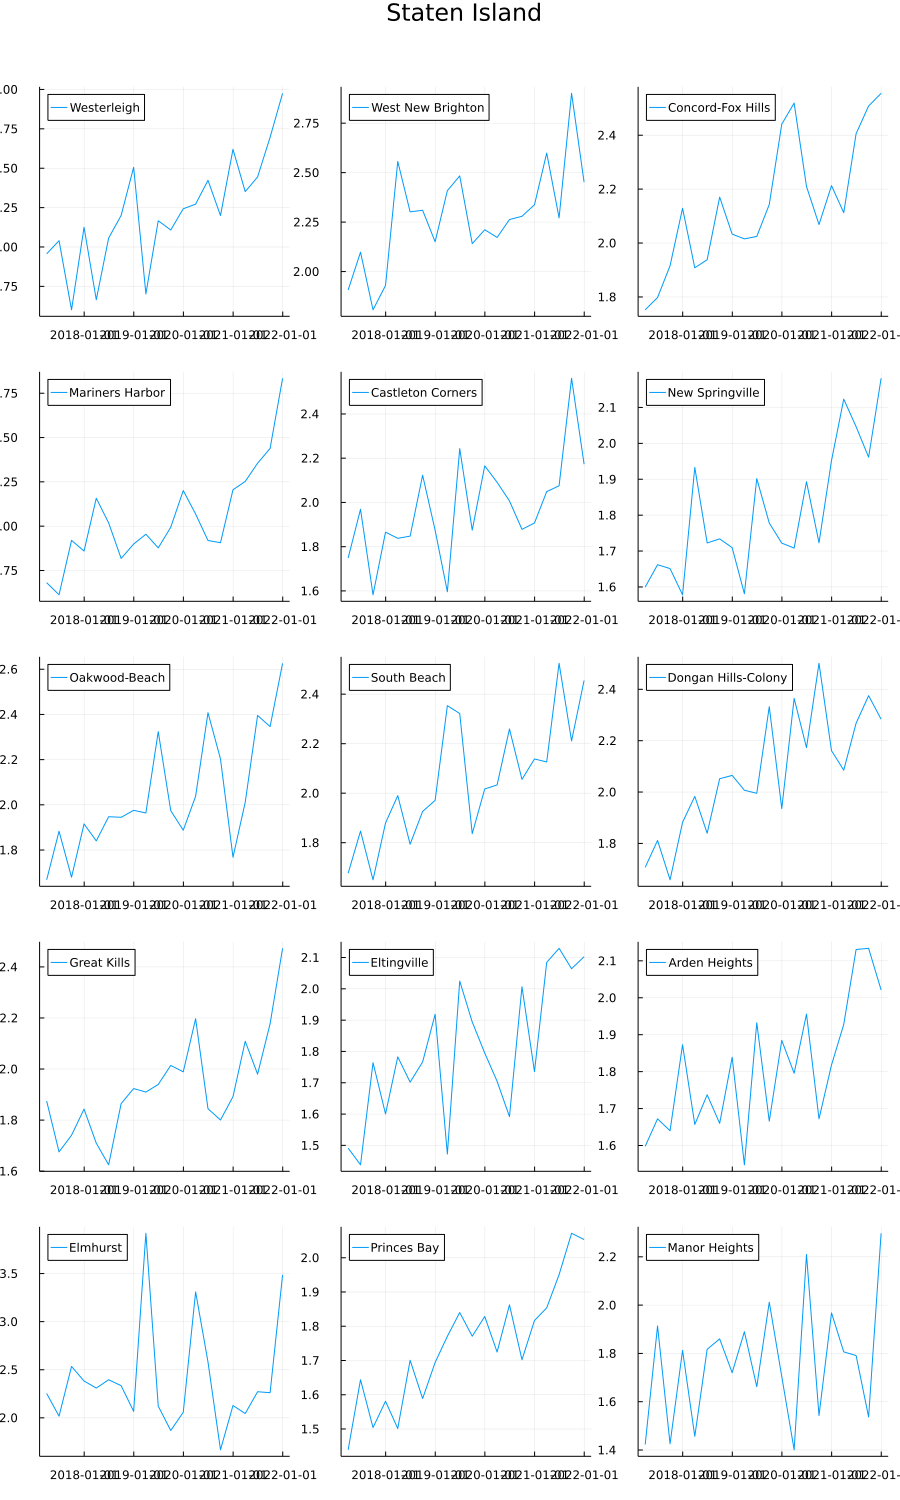

sort!(xₙ, :pct_chg, rev = true) = 18×2 DataFrame
 Row │ neighborhood               pct_chg
     │ String                     Float64
─────┼────────────────────────────────────────
   1 │ Soho                        0.437603
   2 │ Washington Heights Upper    0.414116
   3 │ Tribeca                     0.411716
   4 │ Midtown West                0.232752
   5 │ Chelsea                     0.18781
   6 │ Greenwich Village-Central   0.184426
   7 │ Flatiron                    0.170024
   8 │ Upper East Side (59-79)     0.165905
   9 │ Midtown East                0.158456
  10 │ Upper West Side (59-79)     0.136013
  11 │ Upper East Side (79-96)     0.103355
  12 │ Greenwich Village-West      0.100372
  13 │ Murray Hill                 0.0970505
  14 │ Lower East Side             0.0696739
  15 │ Harlem-Central              0.0416593
  16 │ Financial                  -0.00870741
  17 │ Manhattan Valley           -0.0362849
  18 │ Upper West Side (79-96)    -0.0824882
sort!(xₙ, :pct_chg, re

In [6]:
for ((borough,), dfb) in pairs(groupby(df, :borough))
    gdfn = groupby(dfb, :neighborhood)
    idxn = combine(gdfn) do sdf
        calc_index(sdf)
    end
    idxb = unstack(idxn, :neighborhood, :index)
    idxb = idxb[idxb.dates .> Date("2016-12-31"), :]
    n = length(names(idxb)) - 1
    m = n ÷ 3 + (n % 3 == 0 ? 0 : 1)
    
    yoy = select(idxb, [1] .=> :date, Symbol.(names(idxb)[2:end]) .=> pct_change; renamecols=false)
    xₙ =  DataFrame([names(yoy)[2:end], collect(yoy[end, 2:end])], [:neighborhood, :pct_chg])
    @show sort!(xₙ, :pct_chg, rev=true)    
    display(@df idxb plot(:dates, cols(2:n+1), plot_title=borough, legend=:topleft, 
            layout=(m, 3), size=(900,300 * m)))
end